In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
import pyneb as pn
plt.style.use('ggplot')

In [2]:
def flux_nlr(amp,sigma_eff):
    flux = amp*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff))
    return flux

def spec(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y):
    y = np.sum(np.sum(wo_cube[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2],axis=1),axis=1)
    y_err = np.sqrt(np.sum(np.sum(((wo_err[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2]))**2,axis=1),axis=1))
    return y,y_err

def coupled_fit(wave,data,error,z,p_init_complex):
    k = 1+z
    popt_full_fit,pcov_full_fit = leastsq(complex_gauss_coupled,x0=p_init_complex,args=(wave,data,error),maxfev = 10000000)
    (amp_Ha_core_fit,amp_NII6583_core_fit,amp_SII6716_core_fit,amp_SII6731_core_fit,vel_core_fit,vel_sigma_core_fit,amp_Ha_wing_fit,amp_NII6583_wing_fit,amp_SII6716_wing_fit,amp_SII6731_wing_fit,vel_wing_fit,vel_sigma_wing_fit,amp_Ha_blr1_fit,vel_blr1_fit,vel_sigma_blr1_fit,amp_Ha_blr2_fit,vel_blr2_fit,vel_sigma_blr2_fit,amp_Ha_blr3_fit,vel_blr3_fit,vel_sigma_blr3_fit,m_fit,c_fit)= popt_full_fit
   
    sigma_eff_Ha_core = line_width_recons(vel_sigma_core_fit,rest_line=6562.8,inst_res_fwhm=0)
    sigma_eff_NII_core = line_width_recons(vel_sigma_core_fit,rest_line=6583,inst_res_fwhm=0)
    sigma_eff_SII6716_core = line_width_recons(vel_sigma_core_fit,rest_line=6716,inst_res_fwhm=0)
    sigma_eff_SII6731_core = line_width_recons(vel_sigma_core_fit,rest_line=6731,inst_res_fwhm=0)

    sigma_eff_Ha_wing = line_width_recons(vel_sigma_wing_fit,rest_line=6562.8,inst_res_fwhm=0)
    sigma_eff_NII_wing = line_width_recons(vel_sigma_wing_fit,rest_line=6583,inst_res_fwhm=0)
    sigma_eff_SII6716_wing = line_width_recons(vel_sigma_wing_fit,rest_line=6716,inst_res_fwhm=0)
    sigma_eff_SII6731_wing = line_width_recons(vel_sigma_wing_fit,rest_line=6731,inst_res_fwhm=0)

    flux_Ha_core = flux_nlr(amp_Ha_core_fit,sigma_eff_Ha_core)
    flux_NII_core = flux_nlr(amp_NII6583_core_fit,sigma_eff_NII_core)
    flux_SII6716_core = flux_nlr(amp_SII6716_core_fit,sigma_eff_SII6716_core)
    flux_SII6731_core = flux_nlr(amp_SII6731_core_fit,sigma_eff_SII6731_core)
    flux_Ha_wing = flux_nlr(amp_Ha_wing_fit,sigma_eff_Ha_wing)
    flux_NII_wing = flux_nlr(amp_NII6583_wing_fit,sigma_eff_NII_wing)
    flux_SII6716_wing = flux_nlr(amp_SII6716_wing_fit,sigma_eff_SII6716_wing)
    flux_SII6731_wing = flux_nlr(amp_SII6731_wing_fit,sigma_eff_SII6731_wing)
    flux_par = [flux_Ha_core,flux_NII_core,flux_SII6716_core,flux_SII6731_core,flux_Ha_wing,flux_NII_wing]
   
    Monte_Carlo_loops = 2
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    flux_MC = np.zeros((6,Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data,error) 
        popt_full_MC,pcov_MC =leastsq(complex_gauss_coupled,x0=popt_full_fit,args=(wave,iteration_data,error),maxfev = 10000000)
        
        (amp_Ha_core_MC,amp_NII6583_core_MC,amp_SII6716_core_MC,amp_SII6731_core_MC,vel_core_MC,vel_sigma_core_MC,amp_Ha_wing_MC,amp_NII6583_wing_MC,amp_SII6716_wing_MC,amp_SII6731_wing_MC,vel_wing_MC,vel_sigma_wing_MC,amp_Ha_blr1_MC,vel_blr1_MC,vel_sigma_blr1_MC,amp_Ha_blr2_MC,vel_blr2_MC,vel_sigma_blr2_MC,amp_Ha_blr3_MC,vel_blr3_MC,vel_sigma_blr3_MC,m_MC,c_MC)= popt_full_MC
        sigma_eff_Ha_core_MC = line_width_recons(vel_sigma_core_MC,rest_line=6562.8,inst_res_fwhm=0)
        sigma_eff_NII_core_MC = line_width_recons(vel_sigma_core_MC,rest_line=6583,inst_res_fwhm=0)
        sigma_eff_SII6716_core_MC = line_width_recons(vel_sigma_core_MC,rest_line=6716,inst_res_fwhm=0)
        sigma_eff_SII6731_core_MC = line_width_recons(vel_sigma_core_MC,rest_line=6731,inst_res_fwhm=0)

        sigma_eff_Ha_wing_MC = line_width_recons(vel_sigma_wing_MC,rest_line=6562.8,inst_res_fwhm=0)
        sigma_eff_NII_wing_MC = line_width_recons(vel_sigma_wing_MC,rest_line=6583,inst_res_fwhm=0)
        sigma_eff_SII6716_wing_MC = line_width_recons(vel_sigma_wing_MC,rest_line=6716,inst_res_fwhm=0)
        sigma_eff_SII6731_wing_MC = line_width_recons(vel_sigma_wing_MC,rest_line=6731,inst_res_fwhm=0)

        flux_Ha_core_MC = flux_nlr(amp_Ha_core_MC,sigma_eff_Ha_core_MC)
        flux_NII_core_MC = flux_nlr(amp_NII6583_core_MC,sigma_eff_NII_core_MC)
        flux_SII6716_core_MC = flux_nlr(amp_SII6716_core_MC,sigma_eff_SII6716_core_MC)
        flux_SII6731_core_MC = flux_nlr(amp_SII6731_core_MC,sigma_eff_SII6731_core_MC)
        flux_Ha_wing_MC = flux_nlr(amp_Ha_wing_MC,sigma_eff_Ha_wing_MC)
        flux_NII_wing_MC = flux_nlr(amp_NII6583_wing_MC,sigma_eff_NII_wing_MC)
        flux_SII6716_wing_MC = flux_nlr(amp_SII6716_wing_MC,sigma_eff_SII6716_wing_MC)
        flux_SII6731_wing_MC = flux_nlr(amp_SII6731_wing_MC,sigma_eff_SII6731_wing_MC)
        
        flux_par_MC = [flux_Ha_core_MC,flux_NII_core_MC,flux_SII6716_core_MC,flux_SII6731_core_MC,flux_Ha_wing_MC,flux_NII_wing_MC]
        parameters_MC[:,l]=popt_full_MC
        flux_MC[:,l]=flux_par_MC
    parameters_err = np.nanstd(parameters_MC,1)  
    flux_err = np.nanstd(flux_MC,1)
    return popt_full_fit,parameters_err,flux_par,flux_err


In [3]:
def amp_complex_table(obj,amp_par,amp_par_err):
    column_names={'amp_Ha_nr_fix':0,'amp_NII6583_nr_fix':1,'amp_SII6716_nr_fix':2,'amp_SII6731_nr_fix':3,'amp_Ha_br_fix':4,'amp_NII6583_br_fix':5}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[amp_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[amp_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_amp_par_compare.fits'%(obj),overwrite=True)

def flux_tab(obj,flux_par,flux_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    column_names={'F_Ha_core':0,'F_NII6583_core':1,'F_SII6716_core':2,'F_SII6731_core':3,'F_Ha_wing':4,'F_NII6583_wing':5}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[flux_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[flux_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_flux_Ha-NII_SII_3arcsecond.fits'%(destination_path_cube,obj,obj),overwrite=True)

    
def kin_Ha_NII_table(obj,kin_Ha_NII_par,kin_Ha_NII_par_err):
    column_names={'vel_Ha_nr_fix':0,'vel_sigma_Ha_nr_fix':1,'vel_Ha_br_fix':2,'vel_sigma_Ha_br_fix':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[kin_Ha_NII_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[kin_Ha_NII_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_kin_par_Ha_NII_compare.fits'%(obj),overwrite=True)
  

In [14]:
def algorithm_script(obj,z,p_init_SII,p_init_complex,prefix_path_cube="/media/mainak/Seagate/ftp.hidrive.strato.com/users/login-carsftp/IFU_data/MUSE",destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    print ('%s'%(obj))
    k = 1+z
    (QSO_cube,QSO_err,QSO_wave,QSO_header) = loadCube('%s/%s/%s.QSO_full.fits'%(prefix_path_cube,obj,obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj)) 
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    print (brightest_pixel_x,brightest_pixel_y)

    select = (QSO_wave > 6400*k) & (QSO_wave < 6850*k)  
    mini_wave = QSO_wave[select]
    mini_cube = QSO_cube[:,brightest_pixel_y-10:brightest_pixel_y+11,brightest_pixel_x-10:brightest_pixel_x+11][select]
        
    (central_spec,central_error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])  
    select2 = (wo_wave>5030*k) & (wo_wave<5050*k)
    cont_data = central_spec[select2]
    S = np.mean(cont_data)
    N = np.std(cont_data)
    S_N = (S/N)
    SN = np.sqrt(mini_cube/S)*S_N
    err = np.sqrt(mini_cube*S)/S_N
    mini_err = err
    
    print (np.min(mini_cube))

    (data,error) = int_spec(mini_cube,mini_err)
    #(mini_cube,mini_err,wo_wave,mini_header) = loadCube('%s/%s/%s.3_arcsec_minicube_Ha.fits'%(destination_path_cube,obj,obj))
    #(data,error) = int_spec(mini_cube,mini_err)
     
    #################### perform the fit with coupling H-alpha + [NII] kinematics with [SII]##########################
    (popt_coupled_fit,parameters_err_coupled,flux_par,flux_err) = coupled_fit(mini_wave,data,error,z,p_init_complex)
    print (popt_coupled_fit)
    plot_coupled_kin(obj,mini_wave,data,error,z,popt_coupled_fit)
    (amp_Ha_core_fit,amp_NII6583_core_fit,amp_SII6716_core_fit,amp_SII6731_core_fit,vel_core_fit,vel_sigma_core_fit,amp_Ha_wing_fit,amp_NII6583_wing_fit,amp_SII6716_wing_fit,amp_SII6731_wing_fit,vel_wing_fit,vel_sigma_wing_fit,amp_Ha_blr1_fit,vel_blr1_fit,vel_sigma_blr1_fit,amp_Ha_blr2_fit,vel_blr2_fit,vel_sigma_blr2_fit,amp_Ha_blr3_fit,vel_blr3_fit,vel_sigma_blr3_fit,m_fit,c_fit)= popt_coupled_fit
    (amp_Ha_core_fit_err,amp_NII6583_core_fit_err,amp_SII6716_core_fit_err,amp_SII6731_core_fit_err,vel_core_fit_err,vel_sigma_core_fit_err,amp_Ha_wing_fit_err,amp_NII6583_wing_fit_err,amp_SII6716_wing_fit_err,amp_SII6731_wing_fit_err,vel_wing_fit_err,vel_sigma_wing_fit_err,amp_Ha_blr1_fit_err,vel_blr1_fit_err,vel_sigma_blr1_fit_err,amp_Ha_blr2_fit_err,vel_blr2_fit_err,vel_sigma_blr2_fit_err,amp_Ha_blr3_fit_err,vel_blr3_fit_err,vel_sigma_blr3_fit_err,m_fit_err,c_fit_err)= parameters_err_coupled
   
     ################ Create the table of amplitudes of H-alpha, NII and SII##################################
    amp_par = [amp_Ha_core_fit,amp_NII6583_core_fit,amp_SII6716_core_fit,amp_SII6731_core_fit,amp_Ha_wing_fit,amp_NII6583_wing_fit]
    amp_par_err = [amp_Ha_core_fit_err,amp_NII6583_core_fit_err,amp_SII6716_core_fit_err,amp_SII6731_core_fit_err,amp_Ha_wing_fit_err,amp_NII6583_wing_fit_err]
    amp_complex_table(obj,amp_par,amp_par_err)
    
    ############ Create the table of Ha+[NII]+[SII] kinematic parameters###########################################
    kin_Ha_NII_par = [vel_core_fit,vel_sigma_core_fit,vel_wing_fit,vel_sigma_wing_fit]
    kin_Ha_NII_par_err = [vel_core_fit_err,vel_sigma_core_fit_err,vel_wing_fit_err,vel_sigma_wing_fit_err]
    kin_Ha_NII_table(obj,kin_Ha_NII_par,kin_Ha_NII_par_err)
    flux_tab(obj,flux_par,flux_err)


HE0412-0803
179 160
0.0009492044283730981
[ 1.08658119e+02  7.07017561e+00  5.56506883e+00  6.43543334e+00
  1.14669299e+04  2.04631979e+02  4.84952853e+01  1.02217692e+01
 -4.68961248e-02 -2.26336140e+00  1.12253098e+04  7.22415345e+02
  1.30976997e+02  1.13551398e+04  1.55651524e+03  2.63072853e+01
  1.12915812e+04  3.95335827e+03  2.00000000e+00  1.14640000e+04
  4.40000000e+03  4.64568406e+00 -4.96786064e+00]


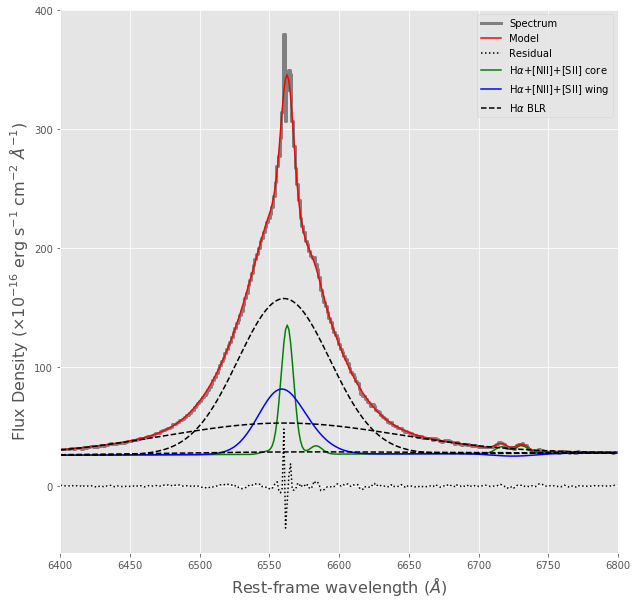

In [18]:
z = {"HE0412-0803":0.038160} # 3 BLR
objs = z.keys()
p_init_complex = {'HE0412-0803':(20,15,5,5,11462,80,5,8,2,2,11464,100,5,11465,1300,5,11464,2300,2,11464,4400,-0.001,0.1)}
p_init_SII = {'HE0412-0803':(5,5,11464,80,2,2,11462,100,-0.001,0.1)}
#b =[(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf), (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]

for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj])

In [19]:
np.log10(7.07017561e+00/(5.56506883e+00 +  6.43543334e+00))

-0.2297692188084002